# Edge Detection with PyTorch

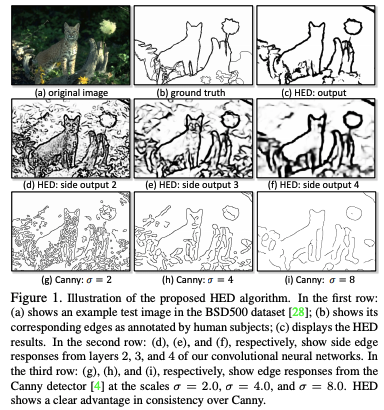

In [1]:
import os, time
import os.path as osp
import math
import numpy as np
import pandas as pd
from PIL import Image
import pylab
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [2]:
!wget http://mftp.mmcheng.net/liuyun/rcf/data/HED-BSDS.tar.gz
!tar -zxvf HED-BSDS.tar.gz

Streaming output truncated to the last 5000 lines.
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/119082.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/35058.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/3096.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/108082.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/80099.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/117054.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/241048.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/155060.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/253055.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/241004.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/42012.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/304034.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/285036.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/175043.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/23025.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/216053.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/286092.png
HED-BSDS/train/aug_gt_scale_0.5/315.0_1_0/292066.png
H

In [13]:
!head -n 10 HED-BSDS/train_pair.lst > HED-BSDS/val_pair.lst

## 1. Explore data

In [4]:
# load the images dataset
dataRoot = 'HED-BSDS/'
trainPath = dataRoot+'train_pair.lst'
valPath = dataRoot+'val_pair.lst'
testPath = dataRoot+'test.lst'

rootDir = dataRoot
frame = pd.read_csv(trainPath, dtype=str, delimiter=' ')

# check some sample images
idx = 1

# input and target images
inputName = os.path.join(rootDir, frame.iloc[idx, 0])
targetName = os.path.join(rootDir, frame.iloc[idx, 1])

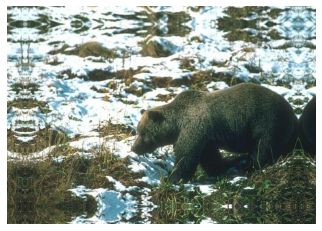

In [5]:
# process the images
inputImage = np.asarray(Image.open(inputName).convert('RGB'))

crop = 32
#inputImage = inputImage[crop:-crop,crop:-crop,:]

plt.figure()
plt.imshow(inputImage)
plt.axis('off')
plt.show()

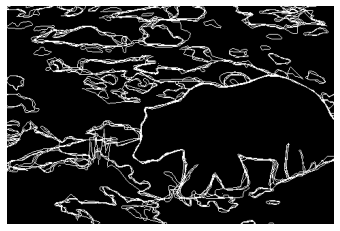

In [6]:
# process input and target images
#targetImage = io.imread(targetName)
targetImage = np.asarray(Image.open(targetName).convert('L'))

crop = 32
targetImage = targetImage[crop:-crop,crop:-crop]

targetImage = targetImage/255.0
targetImage = targetImage > 0.0
targetImage = targetImage.astype(np.float32)

plt.figure()
plt.imshow(targetImage,cmap=cm.gray)
plt.axis('off')
plt.show()

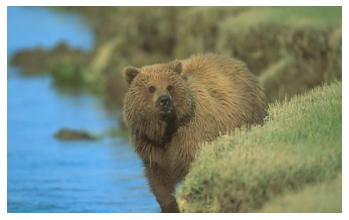

In [7]:
# TODO 1: plot one test image
frame = pd.read_csv(testPath, dtype=str, delimiter=' ')

# check some sample images
idx = 1

# input and target images
inputName = os.path.join(rootDir, frame.iloc[idx, 0])
# process the images
inputImage = np.asarray(Image.open(inputName).convert('RGB'))

crop = 32
inputImage = inputImage[crop:-crop,crop:-crop,:]

plt.figure()
plt.imshow(inputImage)
plt.axis('off')
plt.show()

## 2. Prepare the dataset

In [8]:
# BSDS dataset class for training data
class TrainDataset(Dataset):
    def __init__(self, fileNames, rootDir, 
                 transform=None, target_transform=None): 
        self.rootDir = rootDir
        self.transform = transform
        self.targetTransform = target_transform
        self.frame = pd.read_csv(fileNames, dtype=str, delimiter=' ')

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        # input and target images
        inputName = os.path.join(self.rootDir, self.frame.iloc[idx, 0])
        targetName = os.path.join(self.rootDir, self.frame.iloc[idx, 1])

        # process the images
        inputImage = Image.open(inputName).convert('RGB')
        if self.transform is not None:
            inputImage = self.transform(inputImage)

        targetImage = Image.open(targetName).convert('L')
        if self.targetTransform is not None:
            targetImage = self.targetTransform(targetImage)

        return inputImage, targetImage
    
# dataset class for test dataset
class TestDataset(Dataset):
    def __init__(self, fileNames, rootDir, transform=None):
        self.rootDir = rootDir
        self.transform = transform
        self.frame = pd.read_csv(fileNames, dtype=str, delimiter=' ')

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        # input and target images
        fname = self.frame.iloc[idx, 0]
        inputName = os.path.join(self.rootDir, fname)

        # process the images
        inputImage = Image.open(inputName).convert('RGB')
        if self.transform is not None:
            inputImage = self.transform(inputImage)

        return inputImage, fname

In [9]:
std=[0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]

transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
targetTransform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor()
            ])

In [14]:
nBatch = 1
# create data loaders from dataset
valDataset = TrainDataset(valPath, dataRoot, transform, targetTransform)
trainDataset = TrainDataset(trainPath, dataRoot, transform, targetTransform)

valDataloader = DataLoader(valDataset, batch_size=nBatch, shuffle=False)
trainDataloader = DataLoader(trainDataset, batch_size=nBatch, shuffle=True)

## 3. Prepare the model

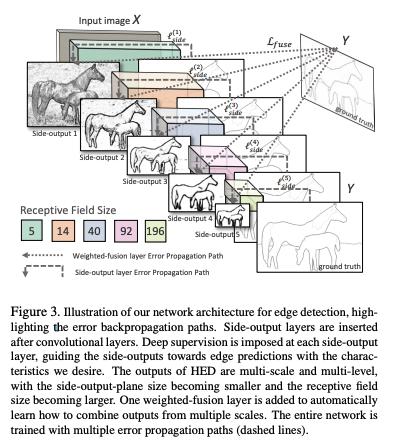

In [15]:
!wget https://download.pytorch.org/models/vgg16-397923af.pth
!mv vgg16-397923af.pth vgg16.pth

--2022-05-17 00:33:46--  https://download.pytorch.org/models/vgg16-397923af.pth
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.112, 18.160.200.71, 18.160.200.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553433881 (528M) [binary/octet-stream]
Saving to: ‘vgg16-397923af.pth’

vgg16-397923af.pth  100%[===================>] 527.79M   172MB/s    in 3.1s    

2022-05-17 00:33:49 (172 MB/s) - ‘vgg16-397923af.pth’ saved [553433881/553433881]



In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    print (classname)
    if classname.find('Conv2d') != -1:
        init.xavier_uniform(m.weight.data)
        init.constant(m.bias.data, 0.1)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def transfer_weights(model_from, model_to):
    wf = copy.deepcopy(model_from.state_dict())
    wt = model_to.state_dict()
    for k in wt.keys():
        if not k in wf:
            wf[k] = wt[k]
    model_to.load_state_dict(wf)

def convert_vgg(vgg16):
	net = vgg()
	vgg_items = list(net.state_dict().items())
	vgg16_items = list(vgg16.items())
	pretrain_model = {}
	j = 0
	for k, v in net.state_dict().items():
	    v = vgg16_items[j][1]
	    k = vgg_items[j][0]
	    pretrain_model[k] = v
	    j += 1
	return pretrain_model

class vgg(nn.Module):
    def __init__(self):
        super(vgg, self).__init__()

        # conv1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=35),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        # conv2
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        # conv3
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/4
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        # conv4
        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/8
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        # conv5
        self.conv5 = nn.Sequential(
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/16
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
        return conv5


class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()

        # conv1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        # conv2
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        # conv3
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/4
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        # conv4
        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/8
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        # conv5
        self.conv5 = nn.Sequential(
            nn.MaxPool2d(2, stride=2, ceil_mode=True),  # 1/16
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.dsn1 = nn.Conv2d(64, 1, 1)
        self.dsn2 = nn.Conv2d(128, 1, 1)
        self.dsn3 = nn.Conv2d(256, 1, 1)
        self.dsn4 = nn.Conv2d(512, 1, 1)
        self.dsn5 = nn.Conv2d(512, 1, 1)
        self.fuse = nn.Conv2d(5, 1, 1)

    def forward(self, x):
        h = x.size(2)
        w = x.size(3)

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        ## side output
        d1 = self.dsn1(conv1)
        d2 = F.upsample_bilinear(self.dsn2(conv2), size=(h,w))
        d3 = F.upsample_bilinear(self.dsn3(conv3), size=(h,w))
        d4 = F.upsample_bilinear(self.dsn4(conv4), size=(h,w))
        d5 = F.upsample_bilinear(self.dsn5(conv5), size=(h,w))

        # dsn fusion output
        fuse = self.fuse(torch.cat((d1, d2, d3, d4, d5), 1))
        
        d1 = F.sigmoid(d1)
        d2 = F.sigmoid(d2)
        d3 = F.sigmoid(d3)
        d4 = F.sigmoid(d4)
        d5 = F.sigmoid(d5)
        fuse = F.sigmoid(fuse)

        return d1, d2, d3, d4, d5, fuse

In [17]:
# initialize the network
net = HED()
net.apply(weights_init)

modelPath = 'vgg16.pth'
pretrained_dict = torch.load(modelPath)
pretrained_dict = convert_vgg(pretrained_dict)

model_dict = net.state_dict()
model_dict.update(pretrained_dict)
net.load_state_dict(model_dict)
net.to('cuda:0')

Conv2d
ReLU
Conv2d
ReLU
Sequential
MaxPool2d
Conv2d
ReLU
Conv2d
ReLU
Sequential
MaxPool2d
Conv2d
ReLU
Conv2d
ReLU
Conv2d
ReLU
Sequential
MaxPool2d
Conv2d
ReLU
Conv2d
ReLU
Conv2d
ReLU
Sequential
MaxPool2d
Conv2d
ReLU
Conv2d
ReLU
Conv2d
ReLU
Sequential
Conv2d
Conv2d
Conv2d
Conv2d
Conv2d
Conv2d
HED


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  


HED(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
  )
  (conv4): Sequenti

In [18]:
# define the optimizer
lr = 1e-4
lrDecay = 1e-1
lrDecayEpoch = {3,5,8,10,12}

fuse_params = list(map(id, net.fuse.parameters()))
conv5_params = list(map(id, net.conv5.parameters()))
base_params = filter(lambda p: id(p) not in conv5_params+fuse_params,
                     net.parameters())

optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': net.conv5.parameters(), 'lr': lr * 100},
            {'params': net.fuse.parameters(), 'lr': lr * 0.001}
            ], lr=lr, momentum=0.9)

## 4. Traing function

In [19]:
class Trainer(object):
    # init function for class
    def __init__(self, generator, optimizerG, trainDataloader, valDataloader,
                 nBatch=10, out='train', maxEpochs=1, cuda=True, gpuID=0,
                 lrDecayEpochs={}):

        # set the GPU flag
        self.cuda = cuda
        self.gpuID = gpuID
        
        # define an optimizer
        self.optimG = optimizerG
        
        # set the network
        self.generator = generator
        
        # set the data loaders
        self.valDataloader = valDataloader
        self.trainDataloader = trainDataloader
        
        # set output directory
        self.out = out
        if not osp.exists(self.out):
            os.makedirs(self.out)
                
        # set training parameters
        self.epoch = 0
        self.nBatch = nBatch
        self.nepochs = maxEpochs
        self.lrDecayEpochs = lrDecayEpochs
        
        self.gamma = 0.1
        self.valInterval = 500
        self.dispInterval = 100
        self.timeformat = '%Y-%m-%d %H:%M:%S'

    def train(self):
        # function to train network
        for epoch in range(self.epoch, self.nepochs):
            # set function to training mode
            self.generator.train()
            
            # initialize gradients
            self.optimG.zero_grad()
            
            # adjust hed learning rate
            if epoch in self.lrDecayEpochs:
                self.adjustLR()

            # train the network
            losses = []
            lossAcc = 0.0
            for i, sample in enumerate(self.trainDataloader, 0):
                # get the training batch
                data, target = sample
                
                if self.cuda:
                    data, target = data.cuda(self.gpuID), target.cuda(self.gpuID)
                data, target = Variable(data), Variable(target)
                
                # generator forward
                tar = target
                d1, d2, d3, d4, d5, d6 = self.generator(data) 
                
                # compute loss for batch
                loss1 = self.bce2d(d1, tar)
                loss2 = self.bce2d(d2, tar)
                loss3 = self.bce2d(d3, tar)
                loss4 = self.bce2d(d4, tar)
                loss5 = self.bce2d(d5, tar)
                loss6 = self.bce2d(d6, tar)
                
                # all components have equal weightage
                loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6
                    
                if np.isnan(float(loss.data)):
                    raise ValueError('loss is nan while training')
                
                losses.append(loss)
                lossAcc += loss.data
                    
                # perform backpropogation and update network
                if i%self.nBatch == 0:
                    bLoss = sum(losses)
                
                    bLoss.backward()
                    self.optimG.step()
                    self.optimG.zero_grad()
                
                    losses = []
                    
                # visualize the loss
                if (i+1) % self.dispInterval == 0:
                    timestr = time.strftime(self.timeformat, time.localtime())
                    print("%s epoch: %d iter:%d loss:%.6f"%(timestr, epoch+1, i+1, lossAcc/self.dispInterval))
                    lossAcc = 0.0
                    
                # perform validation every 500 iters
                if (i+1) % self.valInterval == 0:
                    self.val(epoch+1)
                    
                    # save model after every epoch
                    torch.save(self.generator.state_dict(), '%s/HED.pth' % (self.out))

    def val(self, epoch):
        # eval model on validation set
        print('Evaluation:')
        
        # convert to test mode
        self.generator.eval()
        
        # save the results
        if os.path.exists(self.out + '/images') == False:
            os.mkdir(self.out + '/images')
        dirName = '%s/images'%(self.out)
        
        # perform test inference
        for i, sample in enumerate(self.valDataloader, 0):            
            # get the test sample
            data, target = sample
            
            if self.cuda:
                data, target = data.cuda(self.gpuID), target.cuda(self.gpuID)
            data, target = Variable(data), Variable(target)
            
            # perform forward computation
            d1, d2, d3, d4, d5, d6 = self.generator.forward(data)
            
            # transform to grayscale images
            d1 = self.grayTrans(self.crop(d1))
            d2 = self.grayTrans(self.crop(d2))
            d3 = self.grayTrans(self.crop(d3))
            d4 = self.grayTrans(self.crop(d4))
            d5 = self.grayTrans(self.crop(d5))
            d6 = self.grayTrans(self.crop(d6))
            tar = self.grayTrans(self.crop(target))
            
            d1.save('%s/sample%d1.png' % (dirName, i))
            d2.save('%s/sample%d2.png' % (dirName, i))
            d3.save('%s/sample%d3.png' % (dirName, i))
            d4.save('%s/sample%d4.png' % (dirName, i))
            d5.save('%s/sample%d5.png' % (dirName, i))
            d6.save('%s/sample%d6.png' % (dirName, i))
            tar.save('%s/sample%dT.png' % (dirName, i))
            
        print('evaluate done')
        self.generator.train()
    
    # function to crop the padding pixels
    def crop(self, d):
        d_h, d_w = d.size()[2:4]
        g_h, g_w = d_h-64, d_w-64
        d1 = d[:, :, int(math.floor((d_h - g_h)/2.0)):int(math.floor((d_h - g_h)/2.0)) + g_h, int(math.floor((d_w - g_w)/2.0)):int(math.floor((d_w - g_w)/2.0)) + g_w]
        return d1
    
    def _assertNoGrad(self, variable):
        assert not variable.requires_grad, \
        "nn criterions don't compute the gradient w.r.t. targets - please " \
        "mark these variables as volatile or not requiring gradients"

    # binary cross entropy loss in 2D
    def bce2d(self, input, target):
        n, c, h, w = input.size()
    
        # assert(max(target) == 1)
        
        log_p = input.transpose(1, 2).transpose(2, 3).contiguous().view(1, -1)
        target_t = target.transpose(1, 2).transpose(2, 3).contiguous().view(1, -1)
        
        target_trans = target_t.clone()
        pos_index = (target_t >0)
        neg_index = (target_t ==0)
        target_trans[pos_index] = 1
        target_trans[neg_index] = 0

        pos_index = pos_index.data.cpu().numpy().astype(bool)
        neg_index = neg_index.data.cpu().numpy().astype(bool)

        weight = torch.Tensor(log_p.size()).fill_(0)
        weight = weight.numpy()
        pos_num = pos_index.sum()
        neg_num = neg_index.sum()
        sum_num = pos_num + neg_num
        weight[pos_index] = neg_num*1.0 / sum_num
        weight[neg_index] = pos_num*1.0 / sum_num

        weight = torch.from_numpy(weight)
        weight = weight.cuda()
        loss = F.binary_cross_entropy(log_p, target_t, weight, size_average=True)
        
        return loss

    def grayTrans(self, img):
        img = img.data.cpu().numpy()[0][0]*255.0
        img = (img).astype(np.uint8)
        img = Image.fromarray(img, 'L')
        return img

    # utility functions to set the learning rate
    def adjustLR(self):
        for param_group in self.optimG.param_groups:
            param_group['lr'] *= self.gamma

In [20]:
# initialize trainer class
trainer = Trainer(net, optimizer, trainDataloader, valDataloader, 
                  nBatch=nBatch, maxEpochs=15, cuda=True, gpuID=0,
                  lrDecayEpochs=lrDecayEpoch)

# train the network
trainer.train()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4037: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.form

2022-05-17 00:34:12 epoch: 1 iter:100 loss:1.352222
2022-05-17 00:34:20 epoch: 1 iter:200 loss:0.713831
2022-05-17 00:34:28 epoch: 1 iter:300 loss:0.633507
2022-05-17 00:34:36 epoch: 1 iter:400 loss:0.562196
2022-05-17 00:34:44 epoch: 1 iter:500 loss:0.557724
Evaluation:
evaluate done
2022-05-17 00:34:53 epoch: 1 iter:600 loss:0.531110
2022-05-17 00:35:01 epoch: 1 iter:700 loss:0.485474
2022-05-17 00:35:10 epoch: 1 iter:800 loss:0.481234
2022-05-17 00:35:18 epoch: 1 iter:900 loss:0.475938
2022-05-17 00:35:26 epoch: 1 iter:1000 loss:0.478490
Evaluation:
evaluate done
2022-05-17 00:35:35 epoch: 1 iter:1100 loss:0.455225
2022-05-17 00:35:43 epoch: 1 iter:1200 loss:0.449570
2022-05-17 00:35:51 epoch: 1 iter:1300 loss:0.461541
2022-05-17 00:35:59 epoch: 1 iter:1400 loss:0.448105
2022-05-17 00:36:07 epoch: 1 iter:1500 loss:0.420891
Evaluation:
evaluate done
2022-05-17 00:36:16 epoch: 1 iter:1600 loss:0.433312
2022-05-17 00:36:24 epoch: 1 iter:1700 loss:0.434454
2022-05-17 00:36:32 epoch: 1 i

KeyboardInterrupt: ignored

## 4. Test

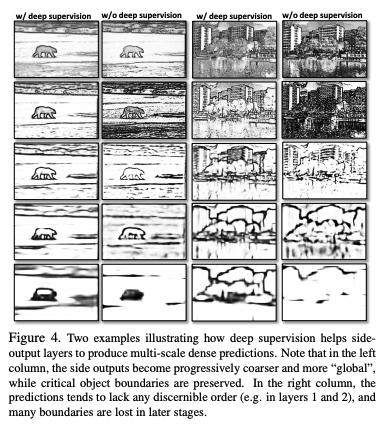

In [21]:
testDataset = TestDataset(testPath, dataRoot, transform)
testDataloader = DataLoader(testDataset, batch_size=1)

In [22]:
def grayTrans(img):
    img = img.numpy()[0][0]*255.0
    img = (img).astype(np.uint8)
    return img

In [23]:
def plotResults(images, size):
    pylab.rcParams['figure.figsize'] = size, size
    
    nPlots = len(images)
    titles = ['org', 'HED', 'S1', 'S2', 'S3', 'S4']
    plt.figure()
    for i in range(0, len(images)):
        s=plt.subplot(1,nPlots,i+1)
        plt.imshow(images[i], cmap = cm.Greys_r)
        s.set_xticklabels([])
        s.set_yticklabels([])
        s.yaxis.set_ticks_position('none')
        s.xaxis.set_ticks_position('none')
        s.set_title(titles[i],fontsize=35)
    plt.tight_layout()
    plt.show()

In [24]:
if not os.path.isdir('test'):
  os.makedirs('test')
nVisualize = 10
for i, sample in enumerate(testDataloader):
    # get input sample image
    inp, fname = sample
    inp = Variable(inp.cuda())
    
    # perform forward computation
    s1,s2,s3,s4,s5,s6 = net.forward(inp)
    
    # convert back to numpy arrays
    out = []
    out.append(grayTrans(s6.data.cpu()))
    out.append(grayTrans(s1.data.cpu()))
    out.append(grayTrans(s2.data.cpu()))
    out.append(grayTrans(s3.data.cpu()))
    out.append(grayTrans(s4.data.cpu()))

    print(fname)
    img = Image.fromarray(out[0], 'L')
    img.save(fname[0].split('.',1)[0]+'.png')

    # visualize every 10th image
    if i%nVisualize == 0:
        plotResults([Image.open(
            os.path.join(dataRoot, 'test', fname[0].split(os.sep)[1])
            ).convert('RGB')] + out, 25)

Output hidden; open in https://colab.research.google.com to view.